In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("clip-vit")
processor = CLIPProcessor.from_pretrained("clip-vit")

img_path = "demo_images/catdog.png"
image = Image.open(img_path)

inputs = processor(
    text = ["a photo of a cat", "a photo of a dog", "a photo of a cat and a dog"], 
    images = image, 
    return_tensors = "pt", 
    padding = True
)

# add output
inputs['output_attentions'] = True
inputs['output_hidden_states'] = True

for keys in inputs.keys():
    print(keys)

/data_all/cjj_node/vit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


input_ids
attention_mask
pixel_values
output_attentions
output_hidden_states


In [10]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
print(probs)

# 提取输出
vision_model_output = outputs.vision_model_output
text_model_output = outputs.text_model_output
vision_atten = vision_model_output.attentions
text_atten = text_model_output.attentions

tensor([[0.0049, 0.0019, 0.9933]], grad_fn=<SoftmaxBackward0>)


In [11]:
print(type(vision_atten),type(text_atten))
vis_atten_last = vision_atten[-1]
print(vis_atten_last.shape)

<class 'tuple'> <class 'tuple'>
torch.Size([1, 16, 257, 257])


In [12]:
print(inputs['pixel_values'].shape) # 发现图像被处理成224 x 224

torch.Size([1, 3, 224, 224])


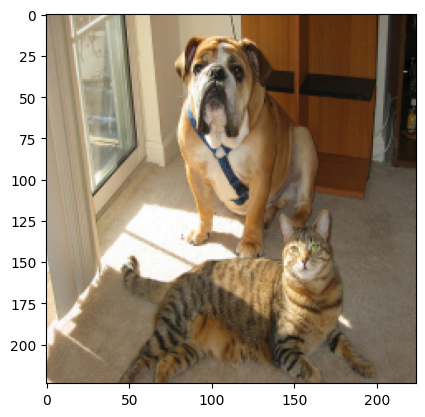

In [13]:
import matplotlib.pyplot as plt
import torchvision

Resize = torchvision.transforms.Resize((224,224))
img = torchvision.io.read_image(img_path)
img_resize = Resize(img)
plt.imshow(img_resize.permute(1,2,0))

In [14]:
import torch
from torch import nn

# 处理atten为可展示格式
def visualize_attention(img,attentions,patch_size):
    """img为原始图片，atten为vit最后一层的atten"""
     # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    return attentions

atten_visual = visualize_attention(img_resize, vis_atten_last, patch_size = 14)


In [15]:
print(atten_visual.shape)

(16, 224, 224)


In [16]:
import numpy as np
def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot((n_heads + 2)//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()

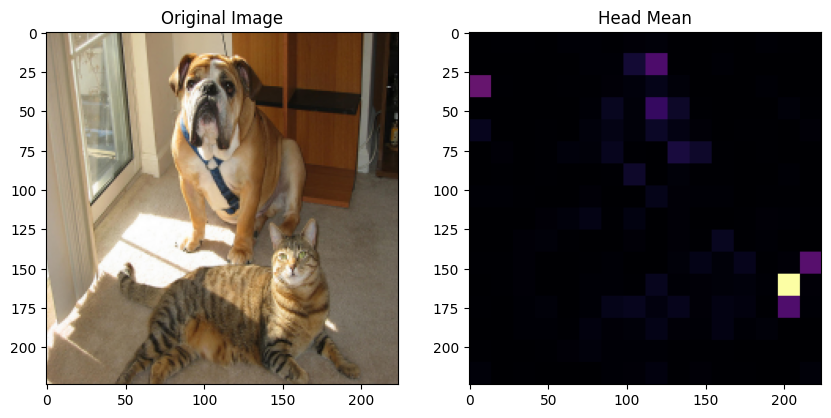

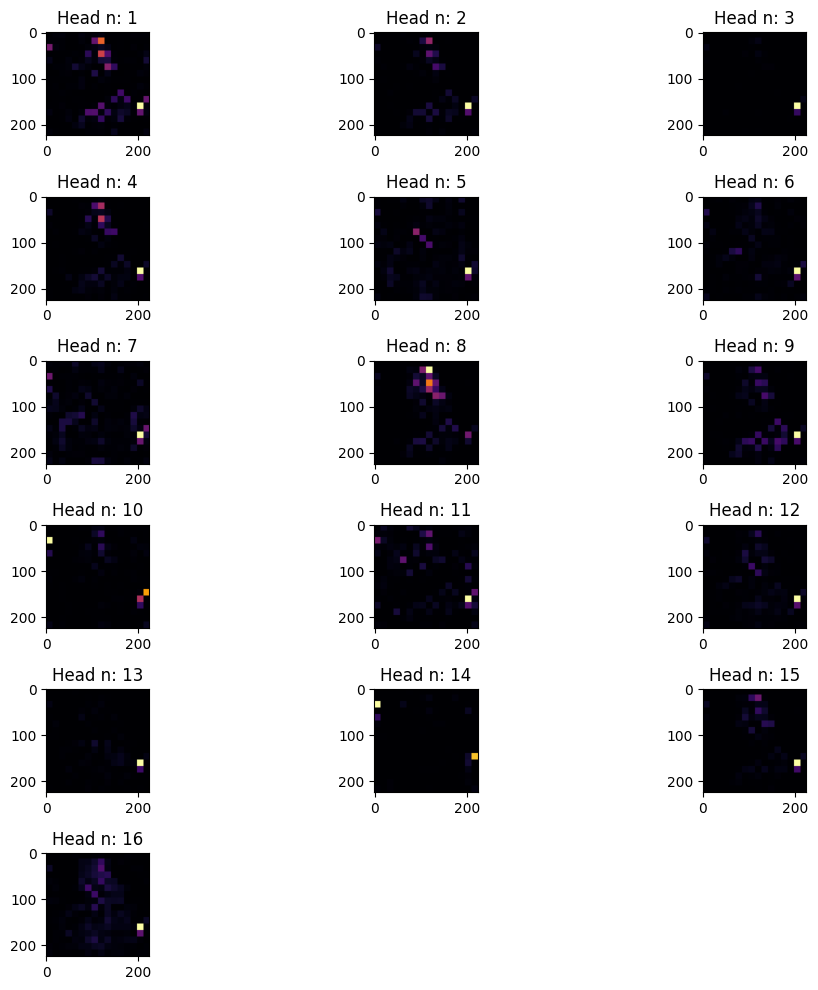

In [17]:
plot_attention(img_resize.permute(1,2,0),atten_visual)